# 0.0 IMPORTS

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy  as np
import warnings 

from datetime import datetime

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 10]

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('amazon.csv')

In [5]:
df_raw.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


# 1.0 DATA DESCRIBE

In [6]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1465
Número de colunas: 16


## 1.2 Data types

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [9]:
df1['rating'].unique()

array(['4.2', '4.0', '3.9', '4.1', '4.3', '4.4', '4.5', '3.7', '3.3',
       '3.6', '3.4', '3.8', '3.5', '4.6', '3.2', '5.0', '4.7', '3.0',
       '2.8', '4', '3.1', '4.8', '2.3', '|', '2', '3', '2.6', '2.9'],
      dtype=object)

In [10]:
df1[df1['rating'] == '|']

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1279,B08L12N5H1,Eureka Forbes car Vac 100 Watts Powerful Sucti...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...","₹2,099","₹2,499",16%,|,992,No Installation is provided for this product|1...,"AGTDSNT2FKVYEPDPXAA673AIS44A,AER2XFSWNN4LAUCJ5...","Divya,Dr Nefario,Deekshith,Preeti,Prasanth R,P...","R2KKTKM4M9RDVJ,R1O692MZOBTE79,R2WRSEWL56SOS4,R...","Decent product,doesn't pick up sand,Ok ok,Must...","Does the job well,doesn't work on sand. though...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Eureka-Forbes-Vacuum-Cle...


In [11]:
df1 = df1[df1['rating'] != '|']

## 1.3 Check NA (%)

In [12]:
df_na = df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100
df_na

rating_count           0.136612
product_id             0.000000
product_name           0.000000
category               0.000000
discounted_price       0.000000
actual_price           0.000000
discount_percentage    0.000000
rating                 0.000000
about_product          0.000000
user_id                0.000000
user_name              0.000000
review_id              0.000000
review_title           0.000000
review_content         0.000000
img_link               0.000000
product_link           0.000000
dtype: float64

In [13]:
df1[df1['rating_count'].isna() == True]

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,80%,3.0,NaN,USB C to C Cable: This cable has type C connec...,AE7CFHY23VAJT2FI4NZKKP6GS2UQ,Pranav,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Amazon-Brand-Charging-Su...
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,₹249,₹999,75%,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...


In [14]:
# Como somente duas linhas possuem valores NaN para rating_count elas serão desconsideradas para a análise
df1 = df1[df1['rating_count'].isna() == False]

## 1.4 Check Duplicates

In [15]:
df_dup = pd.DataFrame(df1['product_id'].value_counts() != 1).reset_index()
prod_dup = df_dup[df_dup['product_id'] == True].nunique()[0]

print('Número de produtos duplicados: {}'.format(prod_dup))

Número de produtos duplicados: 92


In [16]:
df1 = df1.drop_duplicates(subset=['product_id'])

In [17]:
print('Número de linhas: {}'.format(df1.shape[0]))

Número de linhas: 1348


## 1.4 Data Typing

In [18]:
df1.dtypes

product_id             object
product_name           object
category               object
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
rating_count           object
about_product          object
user_id                object
user_name              object
review_id              object
review_title           object
review_content         object
img_link               object
product_link           object
dtype: object

In [19]:
# Removendo simbolo '₹', trocando sinais de decimal de ponto para virgula e alterando tipo para float
df1['discounted_price'] = df1['discounted_price'].apply(lambda x: x.lstrip('₹').replace(',', '')).astype(float)
df1['actual_price'] = df1['actual_price'].apply(lambda x: x.lstrip('₹').replace(',', '')).astype(float)

df1['discount_percentage'] = df1['discount_percentage'].apply(lambda x: x.strip('%')).astype(float)

df1['rating_count'] = df1['rating_count'].apply(lambda x: x.replace(',', '')).astype(int)
df1['rating'] = df1['rating'].astype(float)

In [20]:
df1.dtypes

product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count             int32
about_product           object
user_id                 object
user_name               object
review_id               object
review_title            object
review_content          object
img_link                object
product_link            object
dtype: object

## 1.6 Column treatment

In [21]:
categorys = df1['category'].str.split('|')

In [22]:
col_category = categorys.str.get(0)

In [23]:
df1['new_category'] = col_category

## 1.5 Analisys columns

In [24]:
df1 = df1.drop(columns=['about_product', 
                        'user_name',
                        'review_id',
                        'review_title',
                        'review_content',
                        'img_link',
                        'product_link',
                        'user_id',
                        'category'])

In [25]:
df1.columns

Index(['product_id', 'product_name', 'discounted_price', 'actual_price',
       'discount_percentage', 'rating', 'rating_count', 'new_category'],
      dtype='object')

# 2.0 EXPLORATORY ANALISYS - EDA

In [26]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64'])

## 2.1 Statistic analisys

In [27]:
# Tendência central - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - desvio padrão, min, max, assimetria, curtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'range', 'media', 'mediana', 'std', 'assimetria', 'curtose']
m

,atributos,min,max,range,media,mediana,std,assimetria,curtose
0,discounted_price,39.0,77990.0,77951.0,3310.267188,899.0,7178.237336,4.296700,23.775818
1,actual_price,39.0,139900.0,139861.0,5700.506395,1795.0,11225.190149,4.428165,27.867515
2,discount_percentage,0.0,94.0,94.0,46.662463,49.0,21.599700,-0.237480,-0.599828
3,rating,2.0,5.0,3.0,4.091988,4.1,0.295030,-1.245494,4.253176
4,rating_count,2.0,426973.0,426971.0,17656.847923,4740.0,42143.203147,5.687163,40.210510


## 2.2 Categorys analisys

### 2.2.1 Products by category

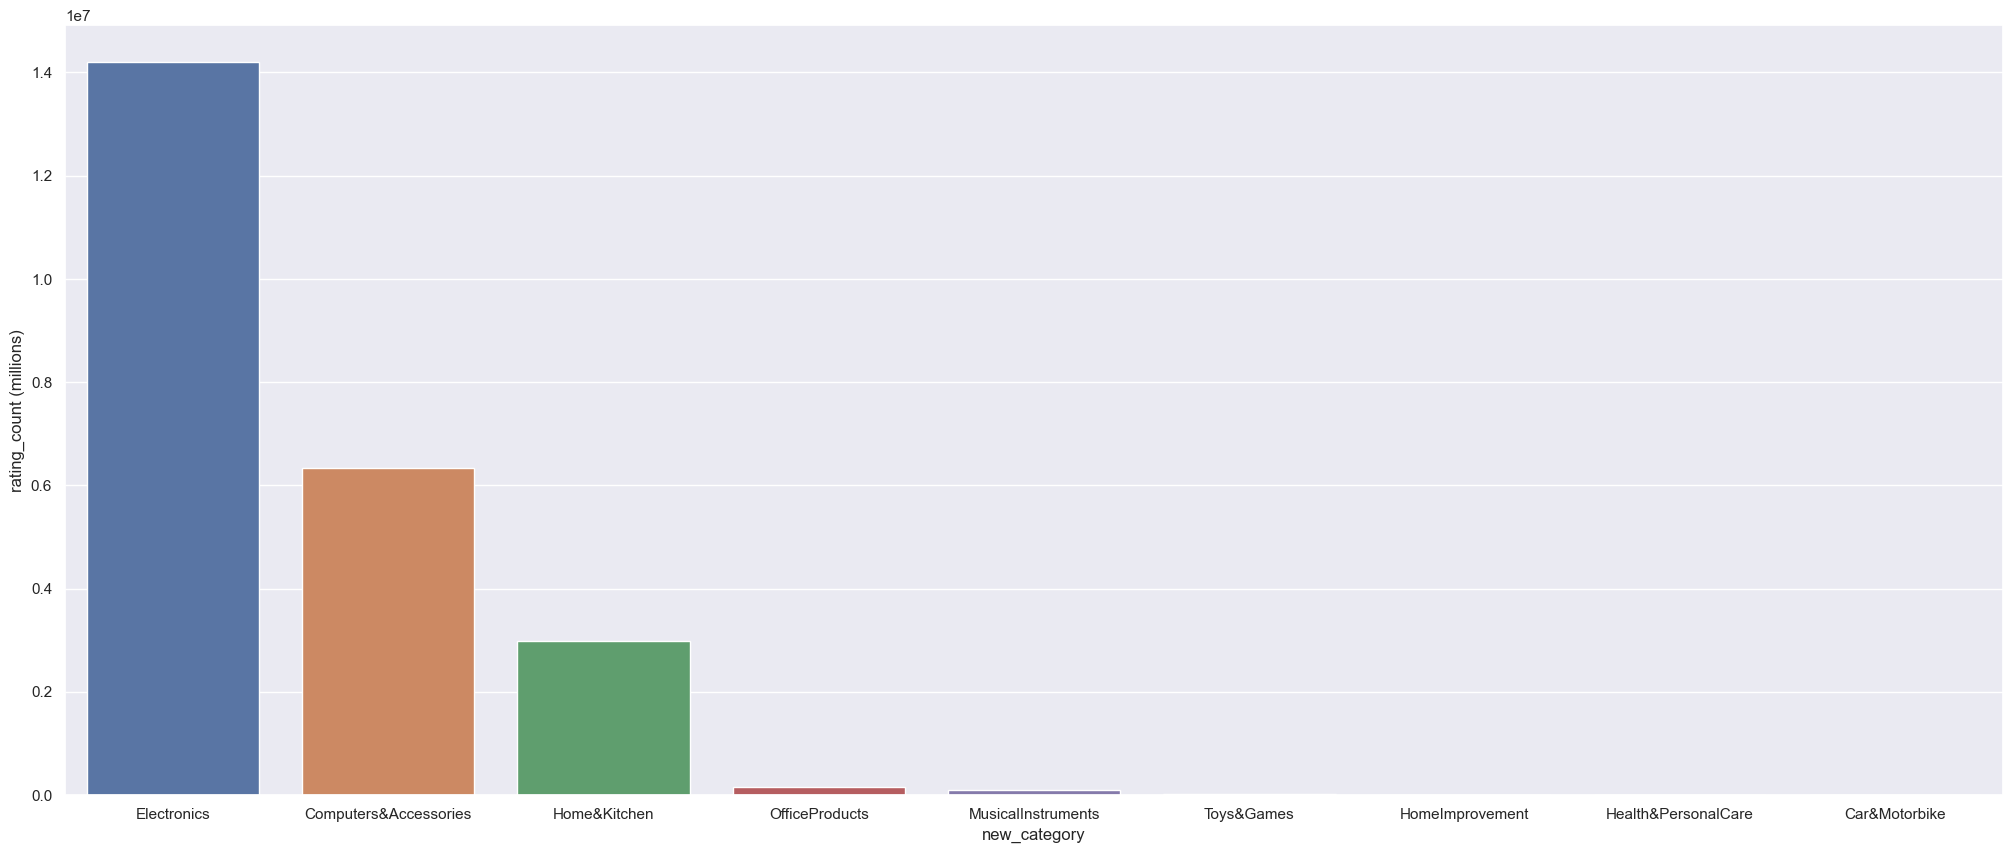

In [28]:
graph1 = df1[['new_category', 'rating_count']].groupby('new_category').sum().sort_values(by='rating_count', ascending=False).reset_index()
sns.barplot(x='new_category', y='rating_count', data=graph1);
plt.ylabel('rating_count (millions)');

### 2.2.2 Average price by category

In [29]:
cats = df1['new_category'].unique()
cats

array(['Computers&Accessories', 'Electronics', 'MusicalInstruments',
       'OfficeProducts', 'Home&Kitchen', 'HomeImprovement', 'Toys&Games',
       'Car&Motorbike', 'Health&PersonalCare'], dtype=object)

In [30]:
dict = {}

for i  in cats:
    
    df_filtered = df1[df1['new_category'].isin([i])][['new_category', 'actual_price', 'rating_count']]
    
    wgt_avg = weighted_avg(df_filtered['actual_price'], df_filtered['rating_count'])
    
    dict[i] = wgt_avg

df_weighted_avg = pd.DataFrame([dict]).T.sort_values(by=0, ascending=False).reset_index()
cols = ['categorys', 'weighted_average']
df_weighted_avg.columns = cols
df_weighted_avg

,categorys,weighted_average
0,Electronics,6427.456980
1,Car&Motorbike,4000.000000
2,Home&Kitchen,3497.315731
3,Health&PersonalCare,1900.000000
4,Computers&Accessories,1835.501121
5,MusicalInstruments,1700.198713
6,HomeImprovement,719.522998
7,OfficeProducts,406.071936
8,Toys&Games,150.000000


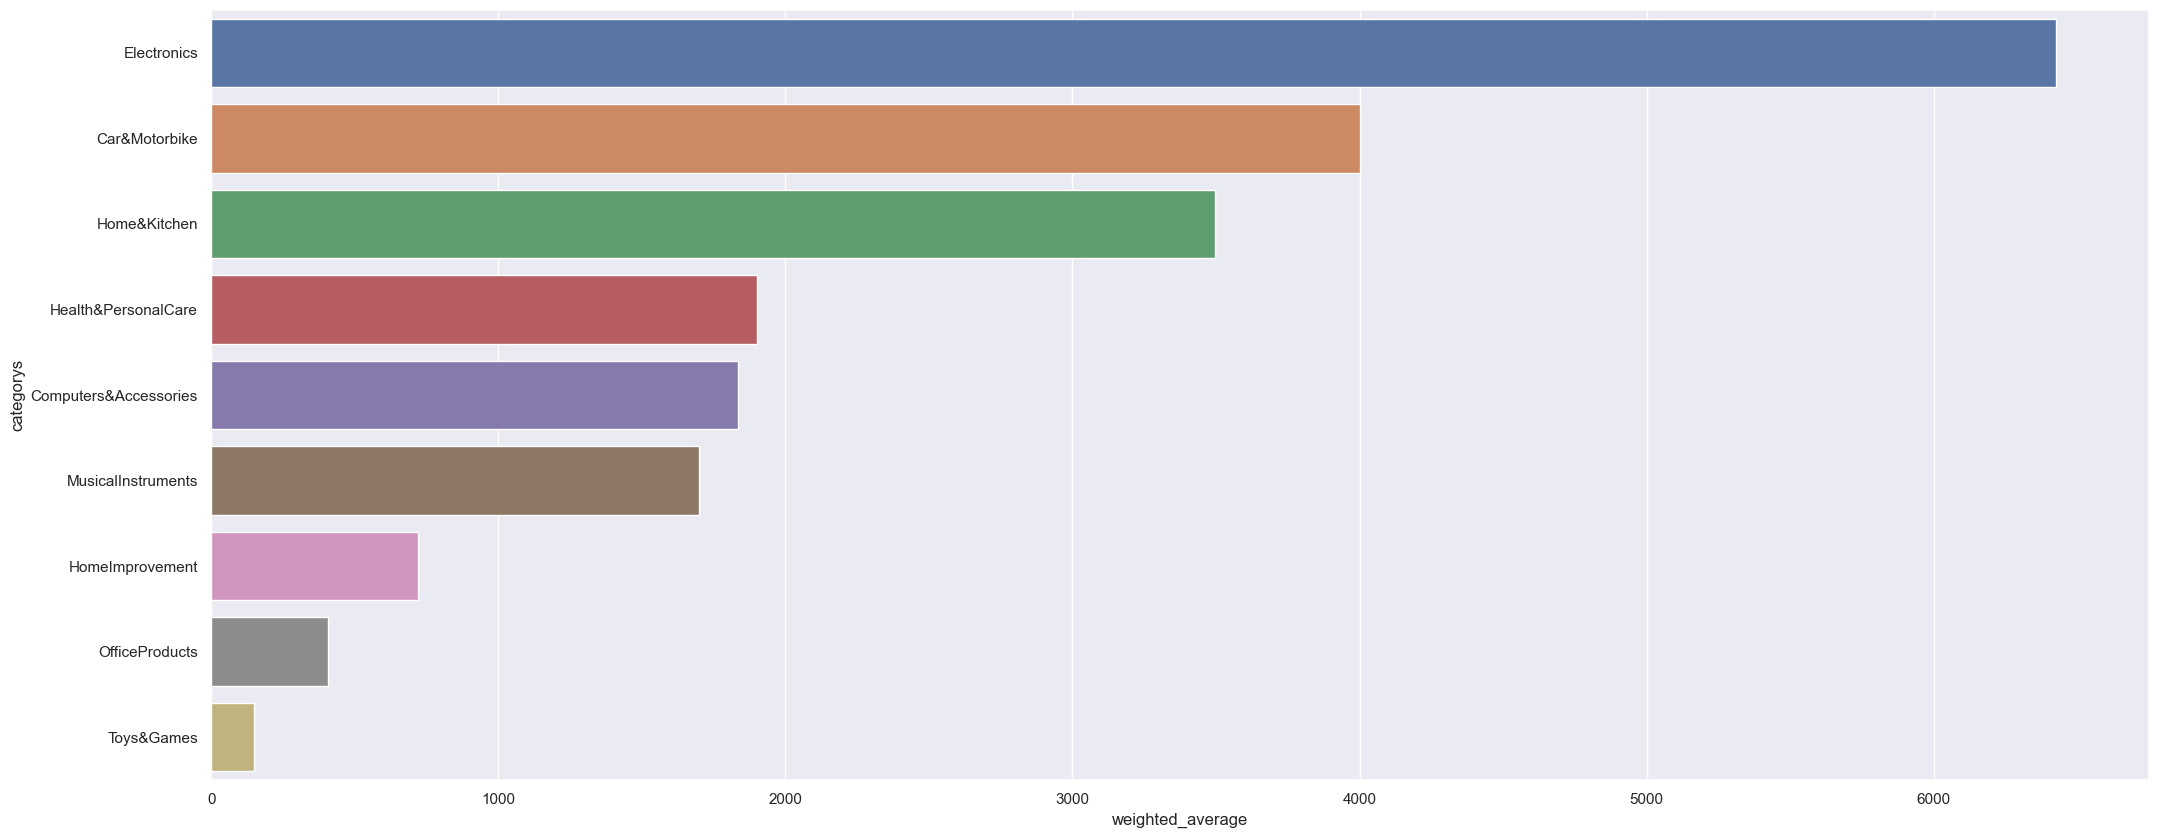

In [31]:
sns.barplot(y='categorys', x='weighted_average', data=df_weighted_avg);

### 2.2.3 Discount distribution by category

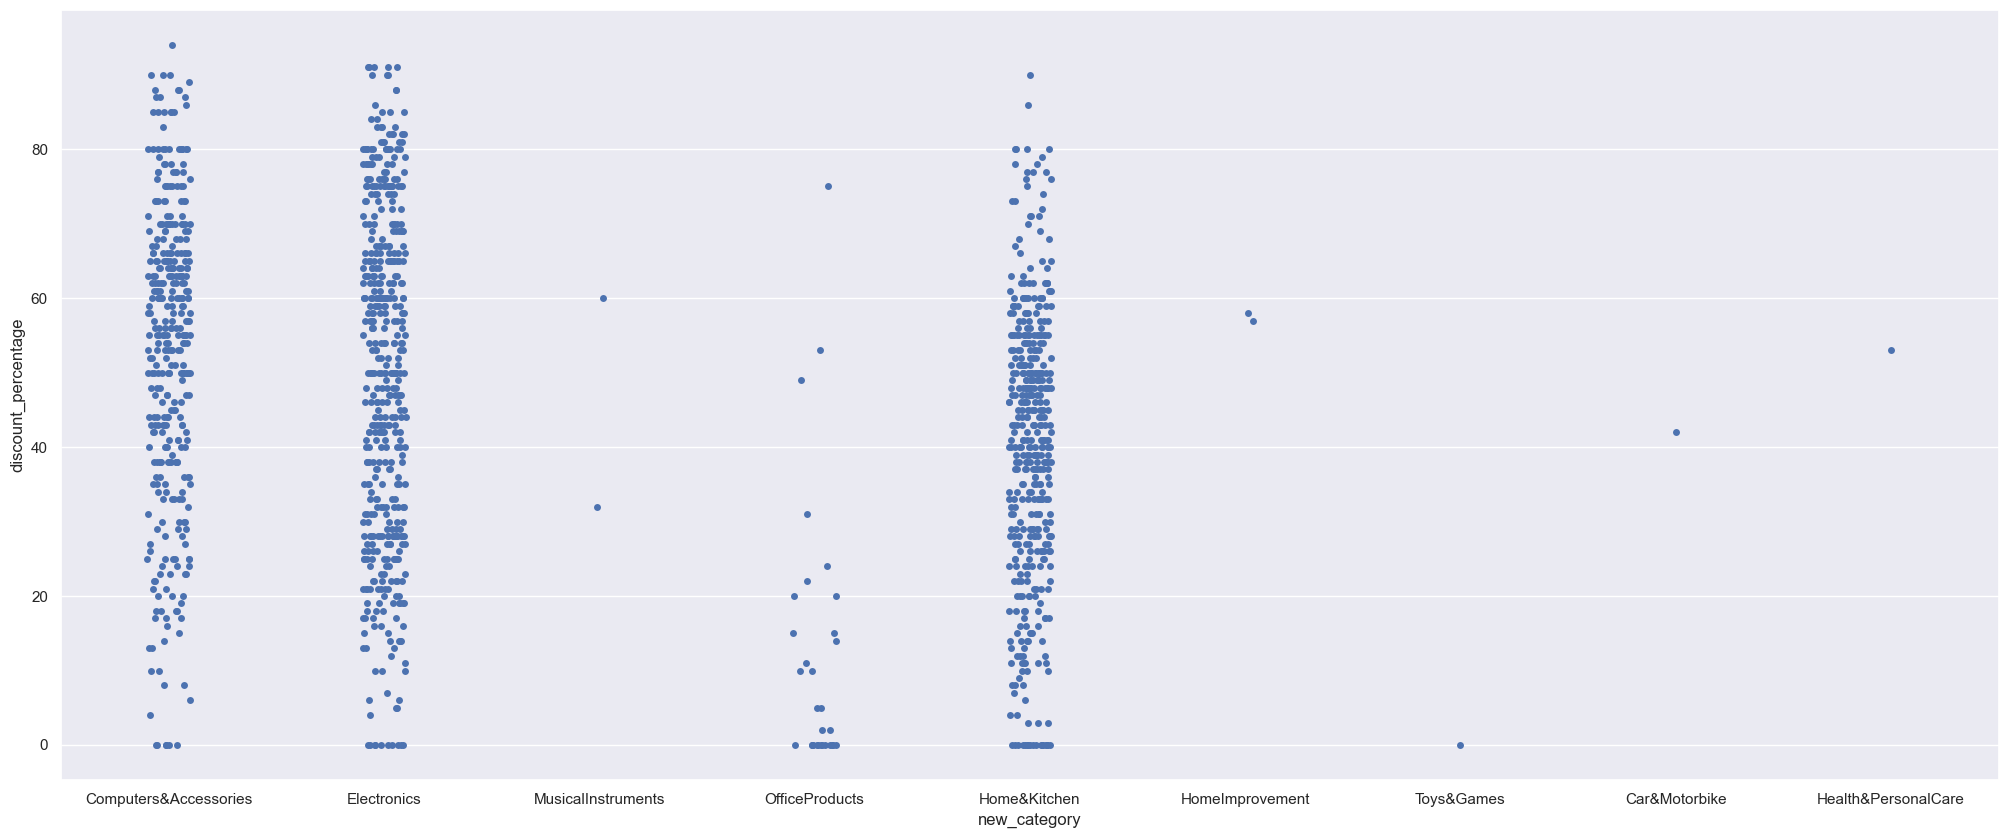

In [32]:
graph3 = df1[['new_category', 'discount_percentage']]
sns.stripplot(x='new_category', y='discount_percentage', data=graph3, jitter=0.1);

### 2.2.4 Rating distribution by categorys (TOP 3 Categorys)

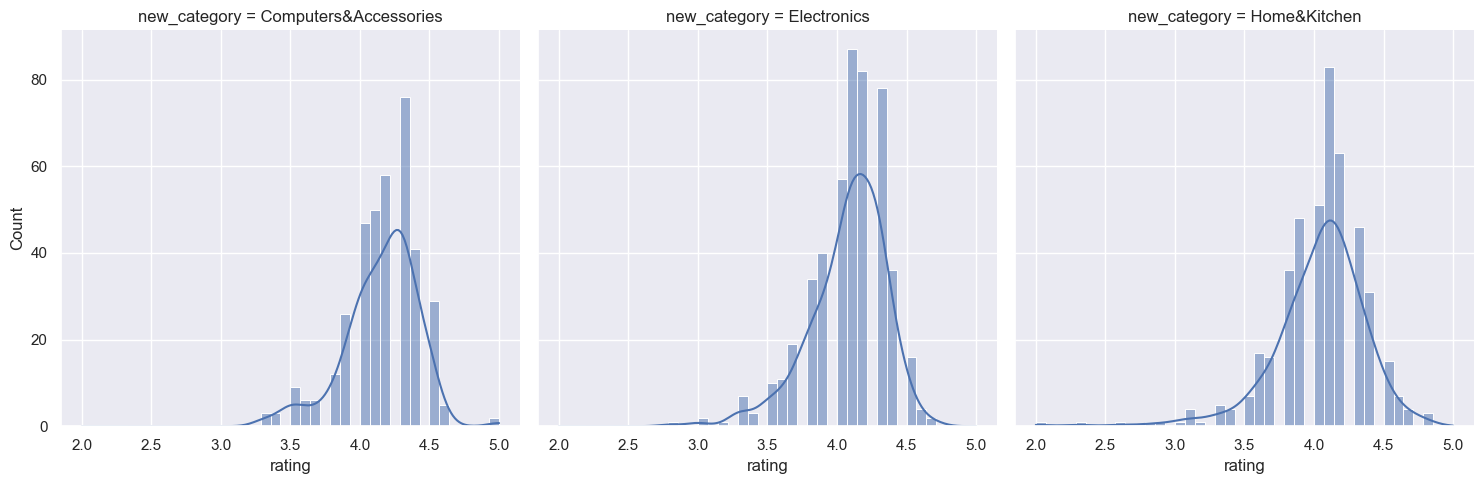

In [33]:
three_category = ['Computers&Accessories', 'Electronics', 'Home&Kitchen']
graph4 = df1[df1['new_category'].isin(three_category)][['new_category', 'rating']]
sns.displot(x='rating', col='new_category', data=graph4, kind='hist', kde=True);

### 2.2.5 Hypothesis: Relation between discount and sells

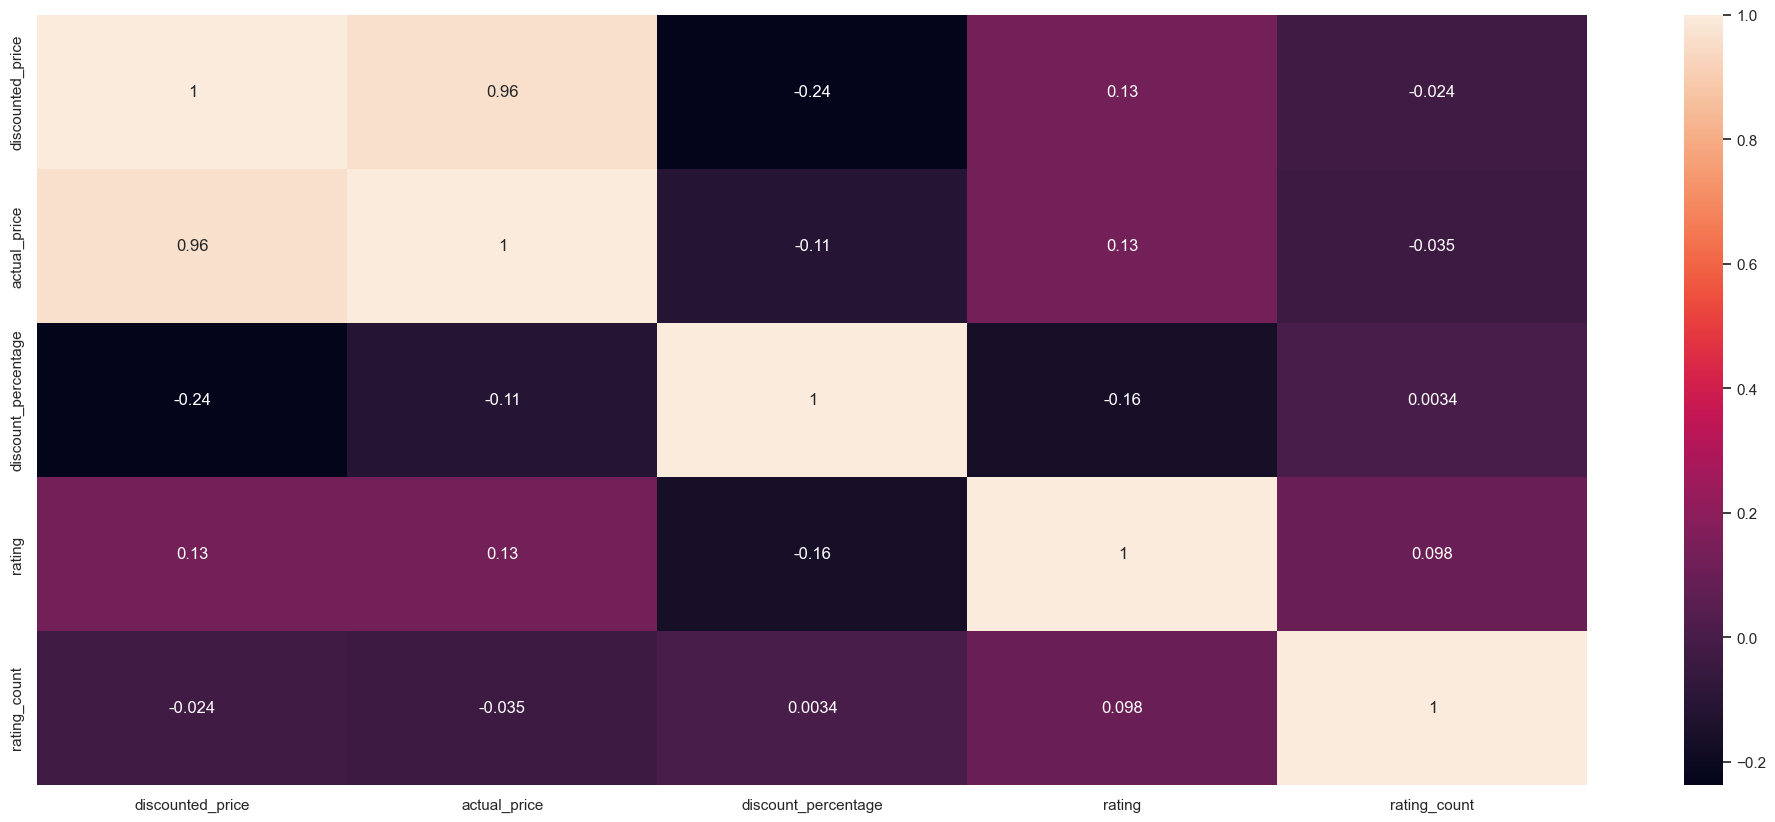

In [34]:
sns.heatmap(num_attributes.corr(), annot=True);

É possível notar que o percentual de desconto (discount_percentage) e a quantidade de vendas (rating_count) dos produtos não estão relacionadas, pois possuem um coeficente de correlação próximo a zero (corr = 0,0034).